In [333]:
#how can we use visualize tiki-taka passing using networks?
#still having issues with 

In [334]:
#import packages
import pandas as pd
import numpy as np
import json
import os
import networkx as nx
import matplotlib.pyplot as plt
import mplsoccer as mpsoccer
from matplotlib import cm, colors
from matplotlib.lines import Line2D

In [335]:
#get the data and convert it to dataframe
data_folder='./open-data/data'

match_id='3750201'
events_file=os.path.join(data_folder, 'events', f'{match_id}.json')

with open(events_file) as f:
    data=json.load(f)

In [336]:
#see how the pass data is structured
#first_pass = next(event for event in data if event['type']['name'] == 'Pass')
#print(json.dumps(first_pass, indent=4))

In [337]:
#filter for pass events
passes=[event for event in data if event['type']['name'] == 'Pass' and event['team']['name'] == 'Barcelona']

#create a df for the pass data
pass_data = pd.DataFrame({
    'Passer': [event['player']['name'] for event in passes],
    'Receiver': [
        event['pass']['recipient']['name'] if 'recipient' in event['pass'] else None
        for event in passes
    ], #drop na values
    'Start X': [event['location'][0] for event in passes],
    'Start Y': [event['location'][1] for event in passes],
    'End X': [event['pass']['end_location'][0] for event in passes],
    'End Y': [event['pass']['end_location'][1] for event in passes]
})

#aggregate all the completed passes
pass_data=pass_data.dropna(subset=['Receiver'])

In [338]:
#average position for each player and put it in a dictionary
average_positions = pass_data.groupby('Passer').agg({'Start X': 'mean', 'Start Y': 'mean'}).to_dict('index')
positions = {player: (pos['Start X'], pos['Start Y']) for player, pos in average_positions.items()}

In [339]:
#define player positions based on the 4-3-3
#positions = {
    #'Víctor Valdés Arribas': (10, 50),
    #'Sylvio Mendes Campos Junior': (25, 20),
    #'Gerard Piqué Bernabéu': (30, 40),
    #'Gnégnéri Yaya Touré': (30, 60),
    #'Carles Puyol i Saforcada': (25, 80),
    #'Andrés Iniesta Luján': (50, 30),  # Full name used
    #'Sergio Busquets i Burgos': (55, 50),
    #'Xavier Hernández Creus': (50, 70),
    #'Thierry Henry': (75, 20),
    #"Samuel Eto''o Fils": (85, 50),
    #'Lionel Andrés Messi Cuccittini': (75, 80)
#}

In [340]:
#filter out passes where the Passer or Receiver is not in the positions dictionary
filtered_pass_data = pass_data[pass_data['Passer'].isin(positions.keys()) & 
                               pass_data['Receiver'].isin(positions.keys())]
pass_count = filtered_pass_data.groupby(['Passer', 'Receiver']).size().reset_index(name='Passes')

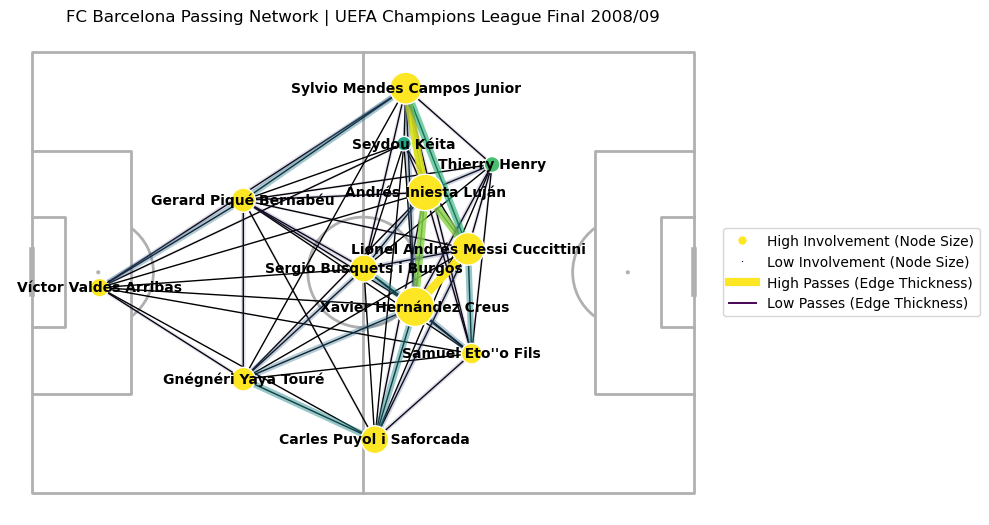

In [341]:
G = nx.from_pandas_edgelist(pass_count, 'Passer', 'Receiver', edge_attr='Passes')

#defining necessary variables for visualization
max_passes = pass_count['Passes'].max()
min_passes = pass_count['Passes'].min()
norm = colors.Normalize(vmin=min_passes, vmax=max_passes)
cmap = plt.cm.viridis

#defining the pitch
pitch = mpsoccer.Pitch(pitch_type='statsbomb', half=False)
fig, ax = pitch.draw(figsize=(10,6))

#node sizes
node_sizes = pass_data['Passer'].value_counts().to_dict()
max_node_size = max(node_sizes.values())
scaled_node_sizes = {player: (size / max_node_size) * 800 for player, size in node_sizes.items()}

#node color intensity
node_color_intensity = [cmap(norm(node_sizes.get(p, 0))) for p in G.nodes()]

nx.draw(G, pos=positions, with_labels=True, node_color=node_color_intensity,
        node_size=[scaled_node_sizes.get(p, 50) for p in G.nodes()],
        edgecolors='white', font_size=10, font_weight='bold', font_family='sans-serif', ax=ax)


for u, v, d in G.edges(data=True):
    pass_count = d['Passes']
    edge_color = cmap(norm(pass_count))
    alpha = norm(pass_count)
    edge_width = np.log1p(pass_count) * 2
    nx.draw_networkx_edges(G, pos=positions, edgelist=[(u, v)], ax=ax,
                           width=edge_width, edge_color=edge_color, alpha=alpha)

#legend elements

high_involvement_size = 70
low_involvement_size = 20

high_pass_thickness = np.log1p(max_passes) * 2
low_pass_thickness = np.log1p(min_passes) * 2

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='High Involvement (Node Size)', markersize=high_involvement_size/10, markerfacecolor=cmap(1.0), markeredgecolor='white'),
    Line2D([0], [0], marker='o', color='w', label='Low Involvement (Node Size)', markersize=low_involvement_size/10, markerfacecolor=cmap(0.0), markeredgecolor='white'),
    Line2D([0], [0], lw=high_pass_thickness, color=cmap(1.0), label='High Passes (Edge Thickness)'),
    Line2D([0], [0], lw=low_pass_thickness, color=cmap(0.0), label='Low Passes (Edge Thickness)')
]

ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

#finalization
plt.title('FC Barcelona Passing Network | UEFA Champions League Final 2008/09')
plt.savefig('./Desktop/fc_barcelona_passing_network_enhanced.png', bbox_inches='tight')
plt.show()